# Wifi Localization Problem Part3

* [0. Previous Preprocessing](#Preprocessing)
* [3. Predictions](#Predictions)
    * [3.1. Cascading Predictions](#Cascade)
        * [3.1.1. BuildingID](#BuildingID)
            * [3.1.1.1. Building Model Performance](#Building_Perf)
        * [3.1.2. Floor](#Floor)
            * [3.1.2.1. Floor Model Performance](#Floor_Perf)
        * [3.1.3. Latitude](#Latitude)
            * [3.1.3.1. Latitude Model Performance](#Latitude_Perf)
        * [3.1.3. Longitude](#Longitude)
            * [3.1.3.4. Longitude Model Performance](#Longitude_Perf)

In [1]:
#Load and import workspace
import dill
#dill.dump_session('notebook_session.db')
#dill.load_session('notebook_session.db')

In [2]:
#Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import math
import scipy

#Import Models
import random
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor

#Model Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

#Cross Validation
from sklearn.model_selection import train_test_split
from math import sqrt

In [3]:
#Import Datasets
wifi = pd.read_csv('trainingData.csv')
wifi_val = pd.read_csv('validationData.csv')
wifi_trainval = pd.concat([wifi,wifi_val])

# <a class="anchor" id="Preprocessing"> 0. Previous Preprocessing and Feat. Engineering </a>

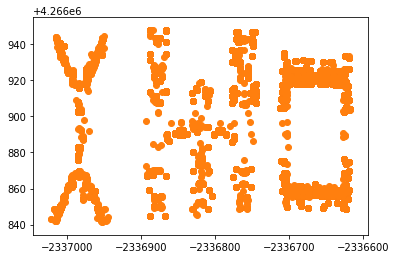

In [4]:
#### SCALE CHANGE ####

wifi_trainval.iloc[:, 0:520] = np.where(wifi_trainval.iloc[:, 0:520] <= 0,
       wifi_trainval.iloc[:, 0:520] + 105,
       wifi_trainval.iloc[:, 0:520] - 100)


#### ORIENTATION CHANGE #####

#TRAIN
angle = np.arctan(wifi["LATITUDE"][0]/wifi["LONGITUDE"][0])
angle = angle/math.pi
LONGITUDE = wifi["LONGITUDE"]*np.cos(angle) + wifi["LATITUDE"]*np.sin(angle)
LATITUDE = wifi["LATITUDE"]*np.cos(angle) - wifi["LONGITUDE"]*np.sin(angle)
plt.scatter(LONGITUDE,LATITUDE)
wifi["LONGITUDE"] = LONGITUDE
wifi["LATITUDE"] = LATITUDE
#MERGED
VLONGITUDE = wifi_trainval["LONGITUDE"]*np.cos(angle) +wifi_trainval["LATITUDE"]*np.sin(angle)
VLATITUDE = wifi_trainval["LATITUDE"]*np.cos(angle) - wifi_trainval["LONGITUDE"]*np.sin(angle)
wifi_trainval["LONGITUDE"] = VLONGITUDE
wifi_trainval["LATITUDE"] = VLATITUDE
plt.scatter(VLONGITUDE,VLATITUDE)
plt.show()

#### DELETE COLUMNS #####

del wifi_trainval['RELATIVEPOSITION']
del wifi_trainval['USERID']
del wifi_trainval['TIMESTAMP']

#### PROBLEMATIC PHONES #####

Phones = [5,7,8,11,12,14,17,19,21]
wifi_trainval = wifi_trainval[~wifi_trainval.PHONEID.isin(Phones)]
#Note: we need to do this before removing duplicated rows

#### DUPLICATED ROWS #####

wifi_trainval = wifi_trainval.drop_duplicates(subset=None, keep='first',inplace=False) 
#754 repeated rows removed (all from train)

#### STRANGE AND LOW SIGNALS #####

wifi_trainval.iloc[:, 0:520] = wifi_trainval.iloc[:, 0:520].replace(np.r_[1:9], 10) 
#Turn useless signals to a single useless number (10)

wifi_trainval.iloc[:, 0:520] = wifi_trainval.iloc[:, 0:520].replace(np.r_[71:106], 70) 
#Reduce perfect signals above 70 to 70.

#### NEW WAP AVERAGE COLUMN #####

#maxWAPvalue = wifi_trainval.iloc[:,0:520].max(axis=1)
#Note: this messes up the model

# <a class="anchor" id="Predictions"> 3. Predictions </a>

Two approaches make the most sense:
1. Training on the 'train set' without splitting and testing on the 'validation set'
2. Merging 'train' and 'validation set', splitting, and testing on ~30% of the data.

In this case, we are using **Approach no. 2** (merging datasets)

## <a class="anchor" id="Cascade"> 3.1. Cascading Predictions </a>

The order for prediction will be: first Building, then Floor, then Latitude and finally Longitude. <br>
The reasonale is the following: <br>
Building is the easiest to predict, since there's only 3 possibilities. Immediately next goes floor.
As for Latitude or Longitude, the reason is not very strong, but Latitude is kind of the 'x' axis in the world map, which defines building (after angle transformation).

In [5]:
#Making sure what number each column is
print(wifi_trainval.columns.get_loc('BUILDINGID'))
print(wifi_trainval.columns.get_loc('FLOOR'))
print(wifi_trainval.columns.get_loc('LATITUDE'))  #The 'X' coordinate
print(wifi_trainval.columns.get_loc('LONGITUDE')) #The 'Y' coordinate

523
522
521
520


### <a class="anchor" id="Split"> 3.1.0. Set up Labels & Split </a>

In [6]:
#Defining Train & Label
x = wifi_trainval.iloc[:,0:520]
y = wifi_trainval.iloc[:,np.r_[520:524]] #Last number is not included
#We select the 4 columns we want to predict, and will choose one in each step

random.seed(101)
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.7)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((7808, 520), (3347, 520), (7808, 4), (3347, 4))

### <a class="anchor" id="BuildingID"> 3.1.1. BuildingID </a>

### Random Forest (Classification)

In [7]:
#RANDOM FOREST
RF_B = RandomForestClassifier(n_estimators =100).fit(x_train,y_train['BUILDINGID'])
print(cross_val_score(RF_B, x_train, y_train['BUILDINGID'], cv=10))

#Predictions
RFpredictions_building = RF_B.predict(x_test)

#Performance Metrics (Errors)
print("Accuracy:", accuracy_score(y_test['BUILDINGID'], RFpredictions_building))
print("Kappa:", cohen_kappa_score(y_test['BUILDINGID'], RFpredictions_building))
print(classification_report(y_test['BUILDINGID'], RFpredictions_building)) #DO NOT UNDERSTAND ALL THIS
confusion_matrix(y_test['BUILDINGID'], RFpredictions_building)

[0.99872123 0.99872123 0.99616368 0.99872123 0.99744246 0.99871795
 0.99871795 0.9974359  0.9987163  0.99743261]
Accuracy: 0.9994024499551838
Kappa: 0.9990706433247367
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       935
           1       1.00      1.00      1.00       878
           2       1.00      1.00      1.00      1534

    accuracy                           1.00      3347
   macro avg       1.00      1.00      1.00      3347
weighted avg       1.00      1.00      1.00      3347



array([[ 935,    0,    0],
       [   0,  876,    2],
       [   0,    0, 1534]])

### Logistic Regression (Classification)

In [35]:
#DON'T FULLY UNDERSTAND THIS (or the warnings)
LR_B = LogisticRegression(
    random_state=0, solver='lbfgs', multi_class='multinomial').fit(x_train ,y_train['BUILDINGID'])
print(cross_val_score(LR_B, x_test, y_test['BUILDINGID'], cv=10))

#Predictions
LRpredictions_building = LR_B.predict(x_test)

#Performance Metrics (Errors)
print("Accuracy:", accuracy_score(y_test['BUILDINGID'], LRpredictions_building))
print("Kappa:", cohen_kappa_score(y_test['BUILDINGID'], LRpredictions_building))
print(classification_report(y_test['BUILDINGID'], LRpredictions_building))
confusion_matrix(y_test['BUILDINGID'], LRpredictions_building)

[1.         0.99402985 0.99701493 0.99701493 1.         0.99701493
 1.         1.         1.         0.99698795]
Accuracy: 0.9988048999103675
Kappa: 0.9981522977036489
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       909
           1       1.00      1.00      1.00       939
           2       1.00      1.00      1.00      1499

    accuracy                           1.00      3347
   macro avg       1.00      1.00      1.00      3347
weighted avg       1.00      1.00      1.00      3347



array([[ 909,    0,    0],
       [   1,  935,    3],
       [   0,    0, 1499]])

### KNN (Classification)

In [36]:
KNN_B = KNeighborsClassifier(n_neighbors=1).fit(x_train, y_train['BUILDINGID'])
print(cross_val_score(KNN_B, x_test, y_test['BUILDINGID'], cv=10))

#Predictions
KNNpredictions_building = KNN_B.predict(x_test)

#Performance Metrics (Errors)
print("Accuracy:", accuracy_score(y_test['BUILDINGID'], KNNpredictions_building))
print("Kappa:", cohen_kappa_score(y_test['BUILDINGID'], KNNpredictions_building))
print(classification_report(y_test['BUILDINGID'], KNNpredictions_building))
confusion_matrix(y_test['BUILDINGID'], KNNpredictions_building)

#K=1 seems to be the best

[0.99701493 0.99104478 0.99402985 1.         0.99402985 1.
 1.         1.         1.         0.99698795]
Accuracy: 0.9979085748431431
Kappa: 0.9967690047309968
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       909
           1       0.99      1.00      1.00       939
           2       1.00      1.00      1.00      1499

    accuracy                           1.00      3347
   macro avg       1.00      1.00      1.00      3347
weighted avg       1.00      1.00      1.00      3347



array([[ 909,    0,    0],
       [   0,  939,    0],
       [   0,    7, 1492]])

### <a class="anchor" id="Building_Perf"> 3.1.1.1 Building Model Performance </a>

In [37]:
BUILDING_Performance = [['Forest', accuracy_score(y_test['BUILDINGID'], RFpredictions_building),
                     cohen_kappa_score(y_test['BUILDINGID'], RFpredictions_building)],
                        ["Logistic Regression", accuracy_score(y_test['BUILDINGID'], LRpredictions_building),
                cohen_kappa_score(y_test['BUILDINGID'], LRpredictions_building)],
                ["KNN", accuracy_score(y_test['BUILDINGID'], KNNpredictions_building),
                cohen_kappa_score(y_test['BUILDINGID'], KNNpredictions_building)]]
                                
df_BUILDING_perf = pd.DataFrame(BUILDING_Performance, columns = ['Model', 'Accuracy','Kappa'])
df_BUILDING_perf

,Model,Accuracy,Kappa
0,Forest,0.998506,0.997690
1,Logistic Regression,0.998805,0.998152
2,KNN,0.997909,0.996769


I'm choosing Logistic Regression

### <a class="anchor" id="Floor"> 3.1.2. Floor </a>

### Random Forest (Classification)

In [38]:
#Creating a new column and pasting the predictions to the test
x_train['BUILDINGID'] = y_train['BUILDINGID']
x_test['BUILDINGID'] = LRpredictions_building

RF_F = RandomForestClassifier().fit(x_train,y_train['FLOOR'])
print(cross_val_score(RF_F, x_train, y_train['FLOOR'], cv=5))

#Predictions
RFpredictions_floor = RF_F.predict(x_test)

#Performance Metrics (Errors)
print("Accuracy:", accuracy_score(y_test['FLOOR'], RFpredictions_floor))
print("Kappa:", cohen_kappa_score(y_test['FLOOR'], RFpredictions_floor))
print(classification_report(y_test['FLOOR'], RFpredictions_floor)) #DO NOT UNDERSTAND THIS
confusion_matrix(y_test['FLOOR'], RFpredictions_floor)

/home/s/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/s/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/s/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



[0.98464491 0.97823303 0.9871877  0.98975016 0.98910955]
Accuracy: 0.9856587989244099
Kappa: 0.9810062627928062
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       633
           1       0.98      0.99      0.98       914
           2       0.99      0.97      0.98       846
           3       0.99      0.99      0.99       887
           4       0.98      0.97      0.98        67

    accuracy                           0.99      3347
   macro avg       0.99      0.98      0.98      3347
weighted avg       0.99      0.99      0.99      3347



array([[627,   5,   1,   0,   0],
       [  5, 904,   3,   2,   0],
       [  1,  18, 824,   3,   0],
       [  3,   0,   4, 879,   1],
       [  0,   0,   0,   2,  65]])

### KNN (Classification)

In [39]:
#Creating a new column and pasting the predictions to the test
x_train['BUILDINGID'] = y_train['BUILDINGID']
x_test['BUILDINGID'] = LRpredictions_building

KNN_F = KNeighborsClassifier(n_neighbors=1).fit(x_train, y_train['FLOOR'])
print(cross_val_score(KNN_F, x_train, y_train['FLOOR'], cv=5))

#Predictions
KNNpredictions_floor = KNN_F.predict(x_test)

#Performance Metrics (Errors)
print("Accuracy:", accuracy_score(y_test['FLOOR'], KNNpredictions_floor))
print("Kappa:", cohen_kappa_score(y_test['FLOOR'], KNNpredictions_floor))
print(classification_report(y_test['FLOOR'], KNNpredictions_floor)) #DO NOT UNDERSTAND THIS
confusion_matrix(y_test['FLOOR'], KNNpredictions_floor)

/home/s/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/s/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.99296225 0.99231754 0.99615631 0.99359385 0.99359385]
Accuracy: 0.9913355243501644
Kappa: 0.9885285569356475
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       633
           1       0.99      0.99      0.99       914
           2       0.99      0.99      0.99       846
           3       0.99      0.99      0.99       887
           4       0.99      0.99      0.99        67

    accuracy                           0.99      3347
   macro avg       0.99      0.99      0.99      3347
weighted avg       0.99      0.99      0.99      3347



array([[631,   1,   1,   0,   0],
       [  6, 905,   2,   1,   0],
       [  1,   6, 836,   3,   0],
       [  3,   0,   3, 880,   1],
       [  0,   0,   0,   1,  66]])

### <a class="anchor" id="Floor_Perf"> 3.1.2.1 Floor Model Performance </a>

In [40]:
FLOOR_Performance = [['Forest', accuracy_score(y_test['FLOOR'], RFpredictions_floor),
                     cohen_kappa_score(y_test['FLOOR'], RFpredictions_floor)],
                ["KNN", accuracy_score(y_test['FLOOR'], KNNpredictions_floor),
                cohen_kappa_score(y_test['FLOOR'], KNNpredictions_floor)]]
                                
df_FLOOR_perf = pd.DataFrame(FLOOR_Performance, columns = ['Model','Accuracy','Kappa'])
df_FLOOR_perf

,Model,Accuracy,Kappa
0,Forest,0.985659,0.981006
1,KNN,0.991336,0.988529


I'm choosing KNN

### <a class="anchor" id="Latitude"> 3.1.3. Latitude </a>

### Random Forest (Regression)

In [41]:
x_train['FLOOR'] = y_train['FLOOR']
x_test['FLOOR'] = KNNpredictions_floor

RF_LAT = RandomForestRegressor().fit(x_train,y_train['LATITUDE'])
print(cross_val_score(RF_LAT, x_train, y_train['LATITUDE'], cv=5))

#Predictions
RFpredictions_latitude = RF_LAT.predict(x_test)

#Performance Metrics (Errors)
rmse = sqrt(mean_squared_error(y_test['LATITUDE'], RFpredictions_latitude))
Rsquared = r2_score(y_test['LATITUDE'],RFpredictions_latitude)
mae = mean_absolute_error(y_test['LATITUDE'],RFpredictions_latitude)
print('R Squared: %.3f' % Rsquared)
print('RMSE: %.3f' % rmse)
print('MAE: %.3f' % mae)

/home/s/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/s/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/s/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



[0.9677072  0.9726942  0.97014024 0.96477835 0.96794434]
R Squared: 0.973
RMSE: 5.235
MAE: 2.716


### KNN (Regression)

In [42]:
x_train['FLOOR'] = y_train['FLOOR']
x_test['FLOOR'] = KNNpredictions_floor

KNN_LAT = KNeighborsRegressor(n_neighbors=1).fit(x_train, y_train['LATITUDE'])
print(cross_val_score(KNN_LAT, x_train, y_train['LATITUDE'], cv=5))

#Predictions
KNNpredictions_latitude = KNN_LAT.predict(x_test)

#Performance Metrics (Errors)
rmse = sqrt(mean_squared_error(y_test['LATITUDE'], KNNpredictions_latitude))
Rsquared = r2_score(y_test['LATITUDE'],KNNpredictions_latitude)
mae = mean_absolute_error(y_test['LATITUDE'],KNNpredictions_latitude)
print('R Squared: %.3f' % Rsquared)
print('RMSE: %.3f' % rmse)
print('MAE: %.3f' % mae)

/home/s/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/s/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.97318919 0.98365873 0.98156914 0.98439183 0.97893424]
R Squared: 0.984
RMSE: 4.111
MAE: 1.422


### <a class="anchor" id="Latitude_Perf"> 3.1.3.1 Latitude Model Performance </a>

In [43]:
LAT_Performance = [['Forest', sqrt(mean_squared_error(y_test['LATITUDE'], RFpredictions_latitude)), 
                 r2_score(y_test['LATITUDE'],RFpredictions_latitude),
                 mean_absolute_error(y_test['LATITUDE'],RFpredictions_latitude)],
                ["KNN", sqrt(mean_squared_error(y_test['LATITUDE'], KNNpredictions_latitude)), 
                 r2_score(y_test['LATITUDE'],KNNpredictions_latitude),
                 mean_absolute_error(y_test['LATITUDE'],KNNpredictions_latitude)]]
                                
df_LAT_perf = pd.DataFrame(LAT_Performance, columns = ['Model', 'RMSE','$R^2$','MAE'])
df_LAT_perf

,Model,RMSE,$R^2$,MAE
0,Forest,5.235261,0.973421,2.715616
1,KNN,4.111143,0.983610,1.421666


I'm choosing KNN, again

### <a class="anchor" id="Longitude"> 3.1.4. Longitude </a>

### Random Forest (Regression)

In [44]:
x_train['LATITUDE'] = y_train['LATITUDE']
x_test['LATITUDE'] = KNNpredictions_latitude

RF_LONG = RandomForestRegressor().fit(x_train,y_train['LONGITUDE'])
print(cross_val_score(RF_LONG, x_train, y_train['LONGITUDE'], cv=5))

#Predictions
RFpredictions_longitude = RF_LONG.predict(x_test)

#Performance Metrics (Errors)
rmse = sqrt(mean_squared_error(y_test['LONGITUDE'], RFpredictions_longitude))
Rsquared = r2_score(y_test['LONGITUDE'], RFpredictions_longitude)
mae = mean_absolute_error(y_test['LONGITUDE'], RFpredictions_longitude)
print('R Squared: %.3f' % Rsquared)
print('RMSE: %.3f' % rmse)
print('MAE: %.3f' % mae)

/home/s/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/s/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/s/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



[0.99773409 0.99837249 0.99749204 0.99790124 0.99801786]
R Squared: 0.995
RMSE: 9.492
MAE: 3.256


In [45]:
x_train['LATITUDE'] = y_train['LATITUDE']
x_test['LATITUDE'] = KNNpredictions_latitude

KNN_LONG = KNeighborsRegressor(n_neighbors=1).fit(x_train,y_train['LONGITUDE'])
print(cross_val_score(KNN_LONG, x_train, y_train['LONGITUDE'], cv=5))

#Predictions
KNNpredictions_longitude = KNN_LONG.predict(x_test)

#Performance Metrics (Errors)
rmse = sqrt(mean_squared_error(y_test['LONGITUDE'], KNNpredictions_longitude))
Rsquared = r2_score(y_test['LONGITUDE'],KNNpredictions_longitude)
mae = mean_absolute_error(y_test['LONGITUDE'],KNNpredictions_longitude)
print('R Squared: %.3f' % Rsquared)
print('RMSE: %.3f' % rmse)
print('MAE: %.3f' % mae)

/home/s/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/s/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.99824915 0.99799035 0.99811027 0.99758993 0.99775763]
R Squared: 0.996
RMSE: 9.106
MAE: 1.980


### <a class="anchor" id="Longitude_Perf"> 3.1.4.1 Longitude Model Performance </a>

In [46]:
LONG_Performance = [['Forest', sqrt(mean_squared_error(y_test['LONGITUDE'], RFpredictions_longitude)), 
                 r2_score(y_test['LONGITUDE'],RFpredictions_longitude),
                 mean_absolute_error(y_test['LONGITUDE'],RFpredictions_longitude)],
                ["KNN", sqrt(mean_squared_error(y_test['LONGITUDE'], KNNpredictions_longitude)), 
                 r2_score(y_test['LONGITUDE'],KNNpredictions_longitude),
                 mean_absolute_error(y_test['LONGITUDE'],KNNpredictions_longitude)]]
                                
df_LONG_perf = pd.DataFrame(LONG_Performance, columns = ['Model', 'RMSE','$R^2$','MAE'])
df_LONG_perf

,Model,RMSE,$R^2$,MAE
0,Forest,9.491588,0.995273,3.255916
1,KNN,9.105991,0.995649,1.979815
